# **GIS × Python Tutorial 4.2 ~ Geometryのメソッドあれこれ ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。


<br>

## **はじめに**
---
前回は **shapely** の Geometry について解説しました。今回は Geometry がもつメソッドの中からよく使うメソッドについて解説していきます。


<br>

In [3]:
import japanize_matplotlib
from matplotlib import pyplot as plt
import numpy as np
import shapely
from shapely.plotting import plot_line
from shapely.plotting import plot_points
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()
plt.style.use('seaborn-v0_8-whitegrid')


print(f"shapely version: {shapely.__version__}")

shapely version: 2.0.3


まずは Geometry を作成します。

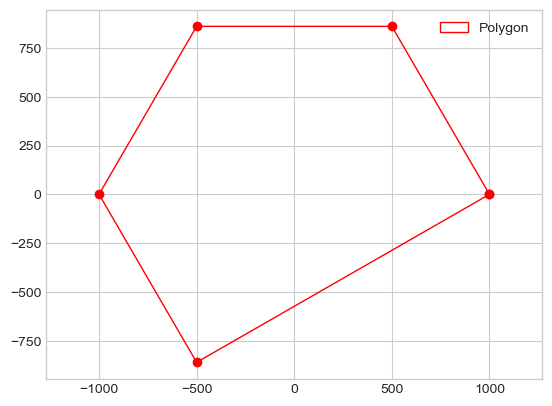

In [4]:
poly = shapely.Polygon(
    [
        [1000.0, 0.0],
        [500.0, 860.6],
        [-500, 860.6], 
        [-1000.0, 00.0],
        [-500.0, -860.6],
    ]
)


def plotting_polygon(poly, label):
    fig, ax = plt.subplots()
    plot_polygon(poly, ax=ax, color='red', facecolor=(0,0,0,0), label=label)
    return ax


ax = plotting_polygon(poly, 'Polygon')
ax.legend()
ax.axis('equal');

## **計算メソッド**
---

### **面積計算**
Polygon の面積計算には polygon.`area` を使用します。正しい面積を計算する場合は投影法にも気を使ってください。

In [5]:
# 面積計算
area = poly.area
print(f"""
平方メートル    : {'{:,}'.format(area)}
ヘクタール      : {'{:,}'.format(area / 10_000)}
平方キロメートル: {'{:,}'.format(area / 1_000_000)}
""")


平方メートル    : 2,151,500.0
ヘクタール      : 215.15
平方キロメートル: 2.1515



### **外周距離の計算**
外周の距離を測る場合は geometry.`length` で計算できます。

In [7]:
length = round(poly.length, 3)

print(f"meter: {'{:,}'.format(length)}")

meter: 5,715.26


### **距離の計算**

距離の計算は geometry.`distance(geometry2)` で測る事が出来ます。

In [5]:
# 2つのPointを作成
pt1 = shapely.Point(0, 0)
pt2 = shapely.Point(0, 20)
# Point間の距離を計算
disance = pt1.distance(pt2)

print(f"Disance: {disance}")

Disance: 20.0


Point間の距離を測る場合はイメージしやすいですね。

## **新たなGeometryを作成するメソッド**
---

### **XY軸に平行な最小領域の取得**
Geometry を囲むXY軸に平行な最小の四角形を取得する場合は geometry.`bounds` を使用します。

戻り値は（min_x, min_y, max_x, max_y）の順でタプルが返ってくるので、shapely.box(min_x, min_y, max_x, max_y) を使用すると最小領域の Polygon を作成する事も可能です。

分かりやすいように Polygon を使用しますが、MultiPoint や LineString などでも使用する事が出来ます。

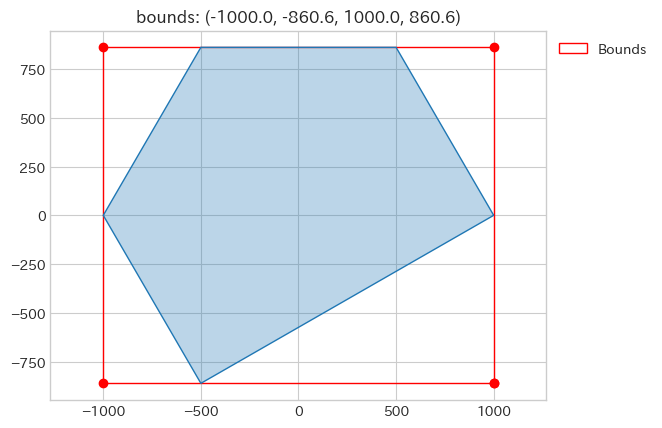

In [14]:
# XY軸に平行な最小領域の取得
bounds = poly.bounds

# XY軸に平行な最小領域のPolygonを作成
bounds_poly = shapely.box(*poly.bounds)


ax = plotting_polygon(bounds_poly, 'Bounds')
ax.set_title(f"bounds: {bounds}")
plot_polygon(poly, ax=ax, add_points=False)
ax.legend(bbox_to_anchor=(1, 1))
ax.axis('equal');

geometry.`envelope` でも同じ結果になります。

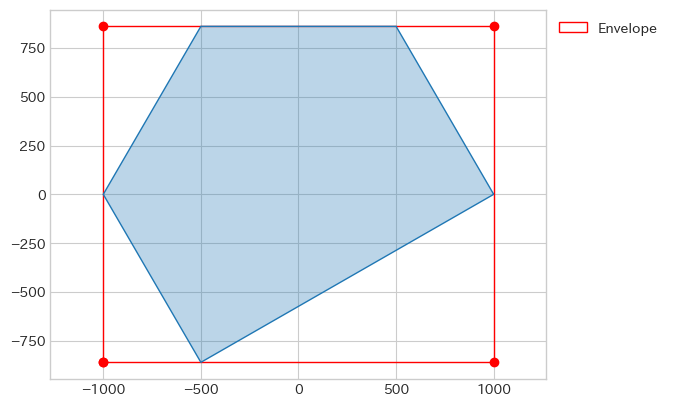

In [15]:
bounds_poly = poly.envelope
ax = plotting_polygon(bounds_poly, 'Envelope')
plot_polygon(poly, ax=ax, add_points=False)
ax.legend(bbox_to_anchor=(1, 1))
ax.axis('equal');

### **最小領域の取得**
Geometry を囲む最小の四角形を取得する場合は geometry.`minimum_rotated_rectangle` を使用します。

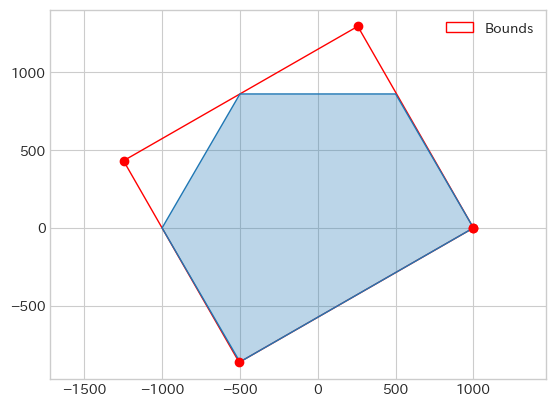

In [16]:
ax = plotting_polygon(poly.minimum_rotated_rectangle, 'Bounds')
plot_polygon(poly, ax=ax, add_points=False)
ax.legend(bbox_to_anchor=(1, 1))
ax.axis('equal');

### **地理的中心の取得**
Geometry の中心を Point のオブジェクトとして取得する為には geometry.`centriod` を使用します。

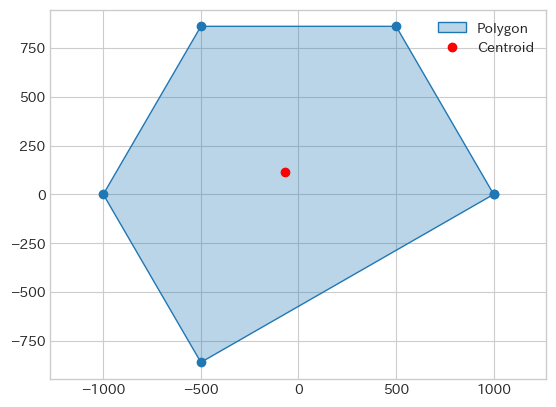

In [17]:
center_point = poly.centroid

fig, ax = plt.subplots()
plot_polygon(poly, ax=ax, label='Polygon')
plot_points(center_point, color='red', label='Centroid')
ax.legend(bbox_to_anchor=(1, 1))
ax.axis('equal');

### **Polygon内にあることが保証されたポイントを作成する**
複雑な形の場合はどうなるのでしょうか。Uの字の様な Polygon で地理的な中心を計算すると、Uの中（Polygonの中ではない）が計算結果として返ってきます。Uの字の中にPointを置きたい場合は geometry.`point_on_surface` を使用しましょう。

(-0.5, 10.5, -0.5, 10.5)

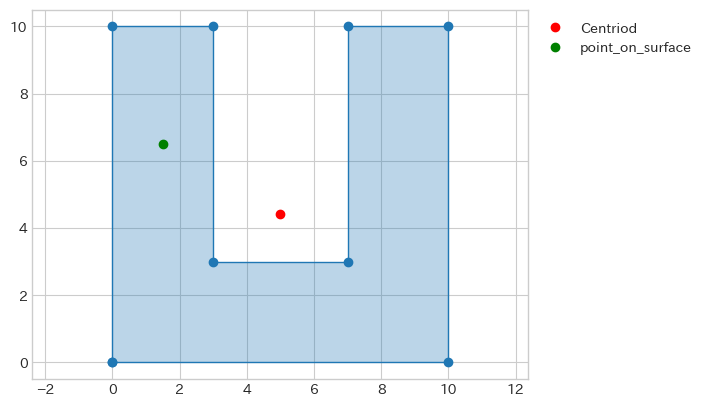

In [18]:
poly_ = shapely.Polygon([
    [0, 0], [0, 10], [3, 10],
    [3, 3], [7, 3], [7, 10],
    [10, 10], [10, 0]
])

center_point = poly_.centroid
point_within = poly_.point_on_surface()

fig, ax = plt.subplots()
plot_polygon(poly_, ax=ax)
plot_points(center_point, color='red', ax=ax, label='Centriod')
plot_points(point_within, color='green', ax=ax, label='point_on_surface')
ax.legend(bbox_to_anchor=(1, 1))
ax.axis('equal')

### **バッファーの作成**
名前のまんまですが、バッファーの作成は geometry.`buffer` を使用し、いくつかの引数を受け取ります。

**distance**
 
 正負の数値を受け取り、数値の分だけバッファーを作成する

**quad_segs | resolution**

1以上の数値を受け取り、バッファーの角の数を決めるイメージです。大きくすればするほど滑らかになります。以前は**resolution**だったはずですが、この記事を書き直す為にドキュメントを見ると**quad_segs**に変更されていました。今のところ resolution でも動作するようです（version 2.0.3）。

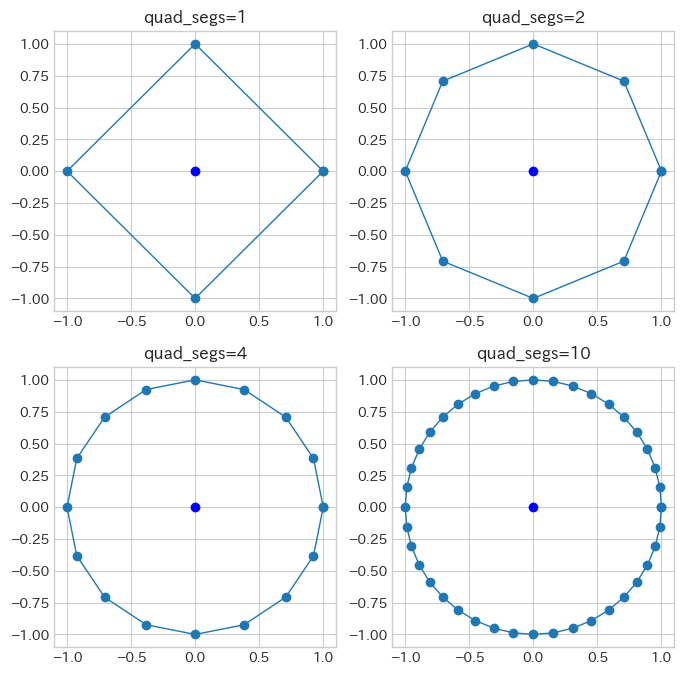

In [50]:
fc = (0,0,0,0)

fig = plt.figure(figsize=(8, 8))
for i, param in enumerate([1, 2, 4, 10]):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title(f"quad_segs={param}")
    plot_points(pt1, color='blue', ax=ax)
    
    # Bufferの作成
    buff = pt1.buffer(1, quad_segs=param)
    plot_polygon(buff, facecolor=fc, ax=ax)


**cap_style**

`shapely.LineString` で端の形状を指定する事が出来ます。'round'では丸くなり、'square'では LineString の端のバッファーが平らになります。'flat'だと端にバッファーは作成されずに平らになります。

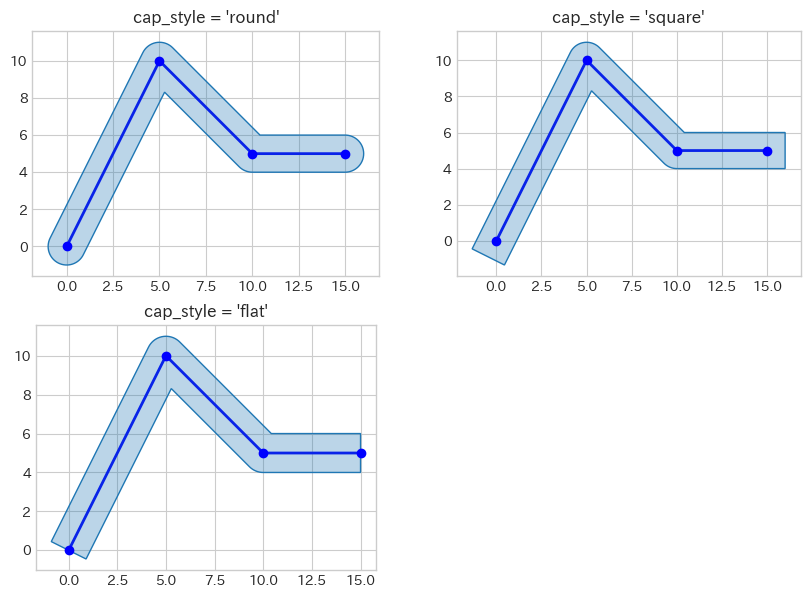

In [117]:
line = shapely.LineString([
    [0, 0], [5, 10], [10, 5], [15, 5]
])

fig = plt.figure(figsize=(10, 7))
for i, shape in enumerate(['round', 'square', 'flat']):
    ax = fig.add_subplot(2, 2, i + 1)
    # Bufferの作成
    buff = line.buffer(1, cap_style=shape)
    plot_line(line, ax=ax, color='blue')
    plot_polygon(buff, add_points=False)
    title = f"cap_style = '{shape}'"
    ax.set_title(title)


**single_sided**

`shapely.LineString` で **single_sided** をTrueにすると、**distance**で指定した距離が正ならば進行方向の左側だけにバッファーが作成され、負ならば右側に作成されます。

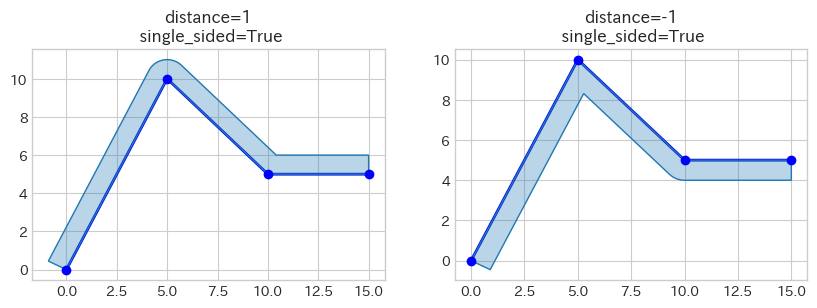

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 3))
for _ax, distance in zip(ax, [1, -1]):
    plot_line(line, color='blue', ax=_ax)
    # Bufferの計算
    buff = line.buffer(distance, single_sided=True)
    plot_polygon(buff, add_points=False, ax=_ax)
    _ax.set_title(
        f"distance={distance}\n single_sided=True"
    ) 

### **内側へ向けたバッファー**
geometry.`buffer`は正の数値だけでなく、負の数値も受け取ります。受け取った数値の分だけ小さな Geometry を返しますが、差分を計算する為のメソッド geometry.`difference` と合わせて使用する事で、Polygon の内側にだけ向けたバッファーを作成する事も出来ます。

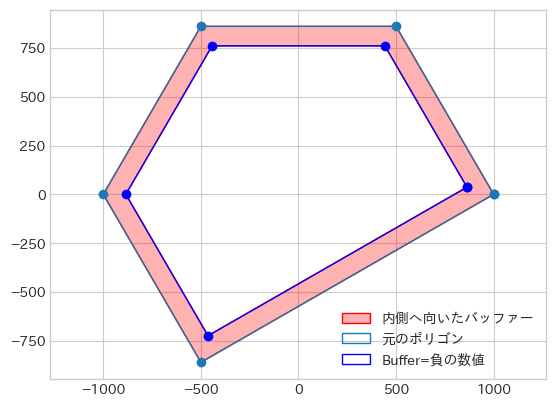

In [57]:
inner_poly = poly.buffer(-100)
inner_belt = poly.difference(inner_poly)

fig, ax = plt.subplots()
plot_polygon(inner_belt, color='red', add_points=False, 
             ax=ax, label='内側へ向いたバッファー')

plot_polygon(poly, facecolor=fc, ax=ax, label='元のポリゴン')
plot_polygon(inner_poly, color='blue', 
             facecolor=fc, ax=ax, 
             label='Buffer=負の数値')
ax.axis('equal')
ax.legend();

### **多重内向きバッファー**
ちょっと変わったものを作成してみましょう。上で内向きのバッファーを作成しましたが、それを多重化して内側を複数のバッファーで埋めてみます。この時 geometry.`minimum_clearance`を使用して次のバッファーが作成可能かを判断します。

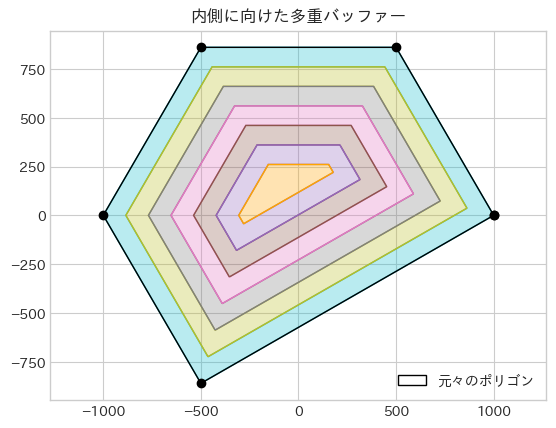

In [113]:
distance = -100
poly_ = poly
inner_poly = poly.buffer(distance)

# 適用する色を作成
cmap = list(plt.colormaps.get_cmap('tab10').colors)
colors = []

inner_belts = []
while True:
    # 内側に向けた帯の様なバッファーを作成
    inner_belt = poly_.difference(inner_poly)
    # クリアランスを計算し、計算を終えるか判断する
    clearance = inner_poly.minimum_clearance
    if (clearance < distance) | (clearance == np.inf):
        break
    poly_ = inner_poly
    inner_poly = poly_.buffer(distance)
    inner_belts.append(inner_belt)
    # 多色を使用するのでここで取得
    if 1 <= len(cmap):
        colors.append(cmap.pop())
    else:
        cmap = list(plt.colormaps.get_cmap('viridis').colors)
        colors.append(cmap.pop())

# 可視化
fig, ax = plt.subplots()
for inner_belt, c in zip(inner_belts, colors):
    plot_polygon(inner_belt, ax=ax, add_points=False, color=c)
plot_polygon(poly_, color='orange', add_points=False, ax=ax)
plot_polygon(poly, color='black', facecolor=fc, label='元々のポリゴン')
ax.set_title('内側に向けた多重バッファー')
ax.legend()
ax.axis('equal');